In [1]:
include("../src/geqrf.jl")
using Random
rng = MersenneTwister(2018)
import LinearAlgebra.dot
import LinearAlgebra.norm
import LinearAlgebra.triu
import LinearAlgebra.diag
using Printf
;

In [2]:
function orthogonal_matrix(m,n)
    # Building an orthogonal matrix Q
    Q = zeros(m,n)
    for j=0:n-1, i=0:m-1
        Q[i+1,j+1] = cos(π*(2i+1)*j/2m)
    end
    for j=1:n
        Q[:,j] /= norm(Q[:,j])
    end
    return Q
end    

orthogonal_matrix (generic function with 1 method)

In [3]:
# Testing QR factorization using CGS
n = 4
m = 8

# Building an orthogonal matrix Q
Q = orthogonal_matrix(m,n)

# Initializing an upper triangular matrix R
R = triu(Float64[ i/j for i=1:n, j=1:n ])

# Matrix A
A = Q*R
# QR factorization
RGS = geqrfCGS!(A)
# The factor Q is stored in A

# These matrices should now be equal
@show norm(Q-A)
@show norm(R-RGS)

norm(Q - A) = 4.999857065771613e-16
norm(R - RGS) = 4.079219866531555e-16


4.079219866531555e-16

In [4]:
function pretty_print(A)
    m = size(A,1)
    n = size(A,2)
    for i=1:m
        for j=1:n
            @printf "%12.3e" A[i,j]
        end
        @printf "\n"
    end
end    

pretty_print (generic function with 1 method)

In [5]:
@show e = 2.0^(-10) * sqrt(eps(Float64))
A0 = [1 1 1; e 0 0; 0 e 0; 0 0 e]
@printf "A\n"
pretty_print(A0)
A = copy(A0); geqrfCGS!(A)
@printf "\nCGS\n"
pretty_print(A)

A = copy(A0); geqrfMGS!(A)
@printf "\nMGS\n"
pretty_print(A)

e = 2.0 ^ -10 * sqrt(eps(Float64)) = 1.4551915228366852e-11
A
   1.000e+00   1.000e+00   1.000e+00
   1.455e-11   0.000e+00   0.000e+00
   0.000e+00   1.455e-11   0.000e+00
   0.000e+00   0.000e+00   1.455e-11

CGS
   1.000e+00   0.000e+00   0.000e+00
   1.455e-11  -7.071e-01  -7.071e-01
   0.000e+00   7.071e-01   0.000e+00
   0.000e+00   0.000e+00   7.071e-01

MGS
   1.000e+00   0.000e+00   0.000e+00
   1.455e-11  -7.071e-01  -4.082e-01
   0.000e+00   7.071e-01  -4.082e-01
   0.000e+00   0.000e+00   8.165e-01


In [6]:
include("../load_plot_pkg.jl")
output = false
if output
    using ORCA
end

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-12084389780233594176\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-16893049587163549528\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-12084389780233594176\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

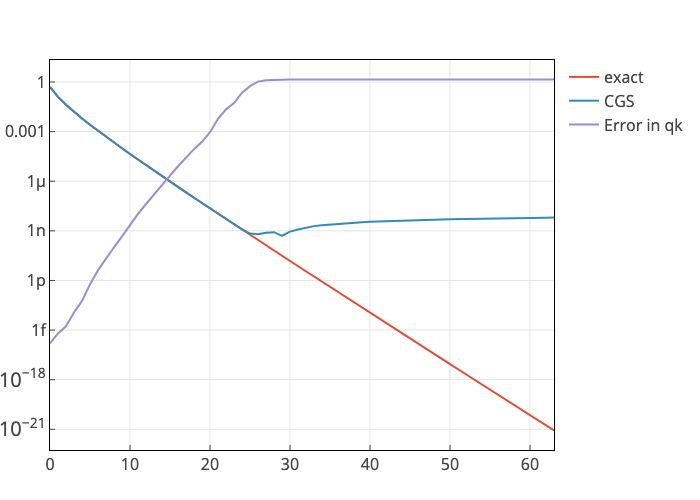

In [7]:
n = 64
m = 128

Q = orthogonal_matrix(m,n)
R = triu(Float64[ 2.0^(-i)/j for i=1:n, j=1:n ])
# R has decaying entries on the diagonal

A = Q*R
CGS = geqrfCGS!(A)

e = zeros(n)
for j=1:n
    e[j] = norm(Q[:,j]-A[:,j])
end

line1 = scatter(y=diag(R),name="exact")
line2 = scatter(y=diag(CGS),name="CGS")
line3 = scatter(y=e,name="Error in qk")
plot([line1, line2, line3],Layout(yaxis_type="log"))

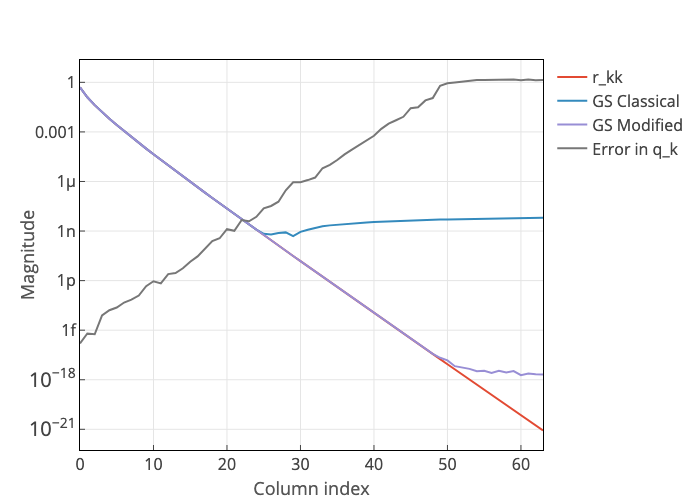

In [8]:
# We use the modified Gram-Schmidt algorithm now
A = Q*R
MGS = geqrfMGS!(A);

e = zeros(n)
for j=1:n
    e[j] = norm(Q[:,j]-A[:,j])
end

t1 = scatter(y=diag(R),name="r_kk")
t2 = scatter(y=diag(CGS),name="GS Classical")
t3 = scatter(y=diag(MGS),name="GS Modified")
t4 = scatter(y=e,name="Error in q_k")
p = plot([t1, t2, t3, t4],Layout(xaxis_title="Column index",yaxis_title="Magnitude",
        yaxis_type="log", width=500, height=300, margin=attr(l=80)))
# It's way more accurate; we reach machine precision

In [9]:
if output
    plotToPDF(p,"fig_cgs")
end